# Binary Classification: Student Risk Triage

## Objective
Build, optimize, and evaluate a fully-tuned binary classification model to identify at-risk students:
- 0 = Not at Risk (Pass or Distinction)
- 1 = At Risk (Fail or Withdrawn)

## CRISP-DM Stage
Modelling and Evaluation

## Rationale
Simplified binary classification focuses intervention on identifying students who need support,
rather than predicting specific final outcomes.

## Approach
1. Test multiple baseline algorithms
2. Cross-validate promising models
3. Hyperparameter optimization on the best model
4. Final evaluation with emphasis on Recall (catch all at-risk students)
5. Serialization for downstream analysis

## Section 1: Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
import xgboost as xgb

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print('All libraries imported successfully')
print('=' * 80)

All libraries imported successfully


## Section 2: Load and Explore Data

In [2]:
print('\n' + '=' * 80)
print('LOADING DATA')
print('=' * 80)

features = pd.read_pickle('../2_Outputs/features_prepared.pkl')
target = pd.read_pickle('../2_Outputs/target_binary.pkl')
df_encoded = pd.read_pickle('../2_Outputs/df_encoded_full.pkl')

print(f'\nFeatures shape: {features.shape}')
print(f'Target shape: {target.shape}')
print(f'\nFeature names ({len(features.columns)} total):')
print(features.columns.tolist()[:10], '...')

print('\n' + '=' * 80)
print('TARGET DISTRIBUTION (Binary Risk Triage)')
print('=' * 80)

class_names = ['Not at Risk', 'At Risk']
print(f'\nClass distribution:')
for idx, name in enumerate(class_names):
    count = (target == idx).sum()
    pct = 100 * count / len(target)
    print(f'  {idx} = {name:15s}: {count:5d} ({pct:5.2f}%)')

print(f'\nNo missing values in target: {target.isnull().sum() == 0}')
print(f'Data types in features: {features.dtypes.nunique()} unique types')


LOADING DATA

Features shape: (32593, 46)
Target shape: (32593,)

Feature names (46 total):
['gender', 'num_of_prev_attempts', 'studied_credits', 'disability', 'total_clicks', 'avg_clicks_per_day', 'std_clicks', 'max_clicks_per_day', 'date_min', 'date_max'] ...

TARGET DISTRIBUTION (Binary Risk Triage)

Class distribution:
  0 = Not at Risk    : 15385 (47.20%)
  1 = At Risk        : 17208 (52.80%)

No missing values in target: True
Data types in features: 4 unique types


## Section 3: Train-Test Split

In [3]:
print('\n' + '=' * 80)
print('STRATIFIED TRAIN-TEST SPLIT')
print('=' * 80)

X_train, X_test, y_train, y_test = train_test_split(
    features, target,
    test_size=0.2,
    random_state=42,
    stratify=target
)

print(f'\nTraining set: {X_train.shape}')
print(f'Test set: {X_test.shape}')

print(f'\nTraining set class distribution:')
for idx, name in enumerate(class_names):
    count = (y_train == idx).sum()
    pct = 100 * count / len(y_train)
    print(f'  {name:15s}: {count:5d} ({pct:5.2f}%)')

print(f'\nTest set class distribution:')
for idx, name in enumerate(class_names):
    count = (y_test == idx).sum()
    pct = 100 * count / len(y_test)
    print(f'  {name:15s}: {count:5d} ({pct:5.2f}%)')


STRATIFIED TRAIN-TEST SPLIT

Training set: (26074, 46)
Test set: (6519, 46)

Training set class distribution:
  Not at Risk    : 12308 (47.20%)
  At Risk        : 13766 (52.80%)

Test set class distribution:
  Not at Risk    :  3077 (47.20%)
  At Risk        :  3442 (52.80%)


## Section 4: Baseline Models

In [4]:
print('\n' + '=' * 80)
print('BASELINE MODEL EVALUATION')
print('=' * 80)

# For binary classification, optimize for Recall (catch all at-risk students)
baseline_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, random_state=42, tree_method='hist', n_jobs=-1, scale_pos_weight=1),
}

baseline_results = {}

for name, model in baseline_models.items():
    print(f'\n{name}:')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred)
    baseline_results[name] = {'model': model, 'accuracy': accuracy, 'recall': recall, 'f1': f1}
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Recall (At-Risk): {recall:.4f}')
    print(f'  F1-Score: {f1:.4f}')

best_baseline = max(baseline_results.items(), key=lambda x: x[1]['recall'])
print(f'\n✓ Best baseline model (by Recall): {best_baseline[0]} (Recall={best_baseline[1]["recall"]:.4f})')


BASELINE MODEL EVALUATION

Logistic Regression:
  Accuracy: 0.9050
  Recall (At-Risk): 0.8504
  F1-Score: 0.9044

Random Forest:
  Accuracy: 0.9233
  Recall (At-Risk): 0.8730
  F1-Score: 0.9232

Gradient Boosting:
  Accuracy: 0.9233
  Recall (At-Risk): 0.8745
  F1-Score: 0.9233

XGBoost:
  Accuracy: 0.9224
  Recall (At-Risk): 0.8847
  F1-Score: 0.9233

✓ Best baseline model (by Recall): XGBoost (Recall=0.8847)


## Section 5: Cross-Validation

In [5]:
print('\n' + '=' * 80)
print('CROSS-VALIDATION (5-Fold Stratified)')
print('=' * 80)

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in baseline_models.items():
    scores = cross_val_score(model, X_train, y_train, cv=cv_strategy, scoring='recall', n_jobs=-1)
    cv_results[name] = scores
    print(f'\n{name}:')
    print(f'  Fold scores: {[f"{s:.4f}" for s in scores]}')
    print(f'  Mean: {scores.mean():.4f} (+/- {scores.std():.4f})')

best_cv_model = max(cv_results.items(), key=lambda x: x[1].mean())
print(f'\n✓ Best CV model (by Recall): {best_cv_model[0]} (Mean Recall={best_cv_model[1].mean():.4f})')


CROSS-VALIDATION (5-Fold Stratified)

Logistic Regression:
  Fold scores: ['0.8733', '0.8678', '0.8700', '0.8740', '0.8736']
  Mean: 0.8717 (+/- 0.0024)

Random Forest:
  Fold scores: ['0.8693', '0.8758', '0.8830', '0.8899', '0.8863']
  Mean: 0.8809 (+/- 0.0074)

Gradient Boosting:
  Fold scores: ['0.8729', '0.8750', '0.8841', '0.8903', '0.8885']
  Mean: 0.8822 (+/- 0.0070)

XGBoost:
  Fold scores: ['0.8813', '0.8892', '0.8943', '0.8979', '0.8928']
  Mean: 0.8911 (+/- 0.0057)

✓ Best CV model (by Recall): XGBoost (Mean Recall=0.8911)


## Section 6: Hyperparameter Tuning

In [6]:
print('\n' + '=' * 80)
print('HYPERPARAMETER OPTIMIZATION (Optimizing for Recall)')
print('=' * 80)

# Define hyperparameter grids for top models
param_grids = {
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10],
        'class_weight': ['balanced', None]
    },
    'Random Forest': {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, None],
        'min_samples_split': [2, 5],
        'class_weight': ['balanced', 'balanced_subsample']
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [5, 7, 9],
        'learning_rate': [0.01, 0.05, 0.1],
        'scale_pos_weight': [1, 2, 3]
    },
}

tuned_models = {}

for model_name in ['Random Forest', 'XGBoost', 'Logistic Regression']:
    if model_name not in param_grids:
        continue
    
    print(f'\nTuning {model_name}...')
    base_model = baseline_models[model_name]
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(
        base_model,
        param_grid,
        cv=5,
        scoring='recall',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    tuned_models[model_name] = grid_search.best_estimator_
    
    print(f'  Best params: {grid_search.best_params_}')
    print(f'  Best CV Recall: {grid_search.best_score_:.4f}')

print('\n✓ Hyperparameter tuning complete')


HYPERPARAMETER OPTIMIZATION (Optimizing for Recall)

Tuning Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
  Best params: {'class_weight': 'balanced_subsample', 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
  Best CV Recall: 0.8806

Tuning XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
  Best params: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 100, 'scale_pos_weight': 3}
  Best CV Recall: 0.9383

Tuning Logistic Regression...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
  Best params: {'C': 0.1, 'class_weight': None}
  Best CV Recall: 0.8763

✓ Hyperparameter tuning complete


## Section 7: Evaluate Tuned Models

In [7]:
print('\n' + '=' * 80)
print('FINAL MODEL EVALUATION (Test Set)')
print('=' * 80)

final_results = {}

for model_name, model in tuned_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    try:
        roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    except:
        roc_auc = None
    
    final_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'y_pred': y_pred
    }
    
    print(f'\n{model_name}:')
    print(f'  Accuracy:  {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall:    {recall:.4f}')
    print(f'  F1-Score:  {f1:.4f}')
    if roc_auc is not None:
        print(f'  ROC-AUC:   {roc_auc:.4f}')

best_model_name = max(final_results.items(), key=lambda x: x[1]['recall'])[0]
best_model = final_results[best_model_name]['model']
print(f'\n✓ BEST MODEL (by Recall): {best_model_name}')
print(f'  Recall: {final_results[best_model_name]["recall"]:.4f}')
print(f'  F1-Score: {final_results[best_model_name]["f1"]:.4f}')


FINAL MODEL EVALUATION (Test Set)

Random Forest:
  Accuracy:  0.9238
  Precision: 0.9798
  Recall:    0.8736
  F1-Score:  0.9237
  ROC-AUC:   0.9689

XGBoost:
  Accuracy:  0.8794
  Precision: 0.8482
  Recall:    0.9399
  F1-Score:  0.8917
  ROC-AUC:   0.9678

Logistic Regression:
  Accuracy:  0.9061
  Precision: 0.9582
  Recall:    0.8597
  F1-Score:  0.9063
  ROC-AUC:   0.9582

✓ BEST MODEL (by Recall): XGBoost
  Recall: 0.9399
  F1-Score: 0.8917


## Section 8: Confusion Matrix and Classification Report


CLASSIFICATION REPORT - XGBoost

              precision    recall  f1-score   support

 Not at Risk       0.92      0.81      0.86      3077
     At Risk       0.85      0.94      0.89      3442

    accuracy                           0.88      6519
   macro avg       0.89      0.88      0.88      6519
weighted avg       0.88      0.88      0.88      6519



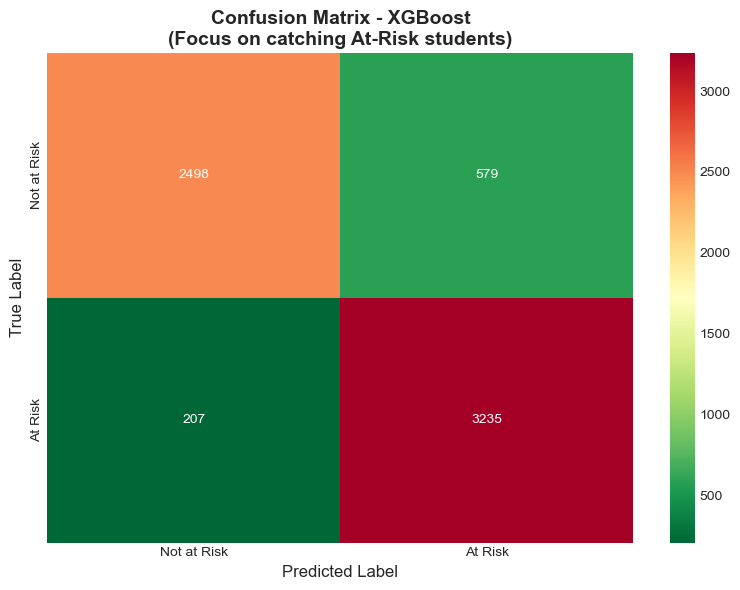


Confusion Matrix Analysis:
  True Negatives (correct Not at Risk): 2498
  False Positives (incorrect At Risk): 579
  False Negatives (missed At Risk): 207 ⚠ (CRITICAL - students needing help)
  True Positives (correct At Risk): 3235


In [8]:
print('\n' + '=' * 80)
print(f'CLASSIFICATION REPORT - {best_model_name}')
print('=' * 80)

y_pred_best = final_results[best_model_name]['y_pred']
print('\n' + classification_report(y_test, y_pred_best, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name}\n(Focus on catching At-Risk students)', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.show()

print(f'\nConfusion Matrix Analysis:')
print(f'  True Negatives (correct Not at Risk): {cm[0,0]}')
print(f'  False Positives (incorrect At Risk): {cm[0,1]}')
print(f'  False Negatives (missed At Risk): {cm[1,0]} ⚠ (CRITICAL - students needing help)')
print(f'  True Positives (correct At Risk): {cm[1,1]}')

## Section 9: ROC Curve


ROC CURVE - XGBoost


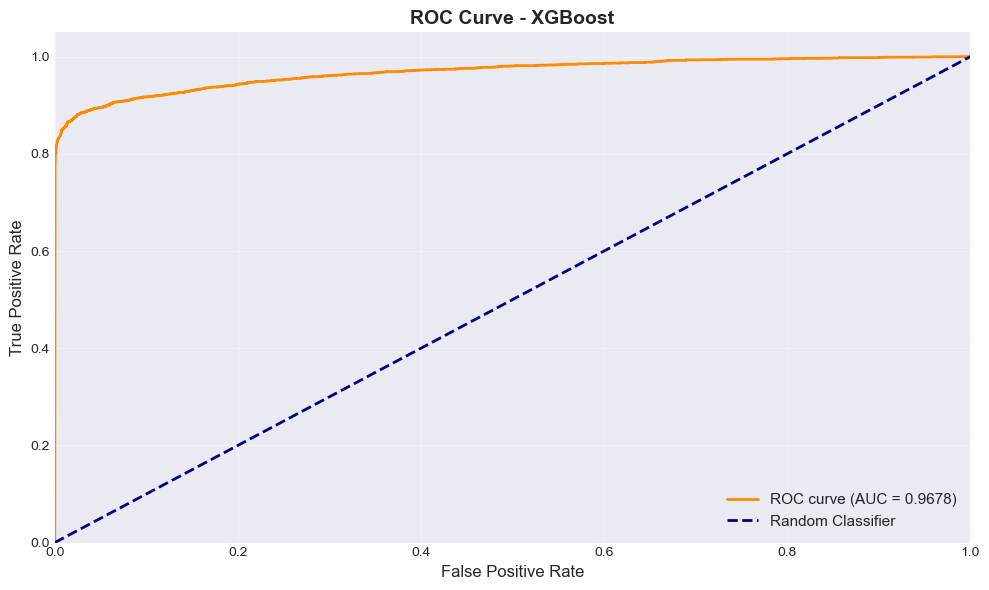

In [9]:
print('\n' + '=' * 80)
print(f'ROC CURVE - {best_model_name}')
print('=' * 80)

try:
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curve - {best_model_name}', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
except:
    print('ROC curve not available for this model')

## Section 10: Feature Importance


FEATURE IMPORTANCE - XGBoost


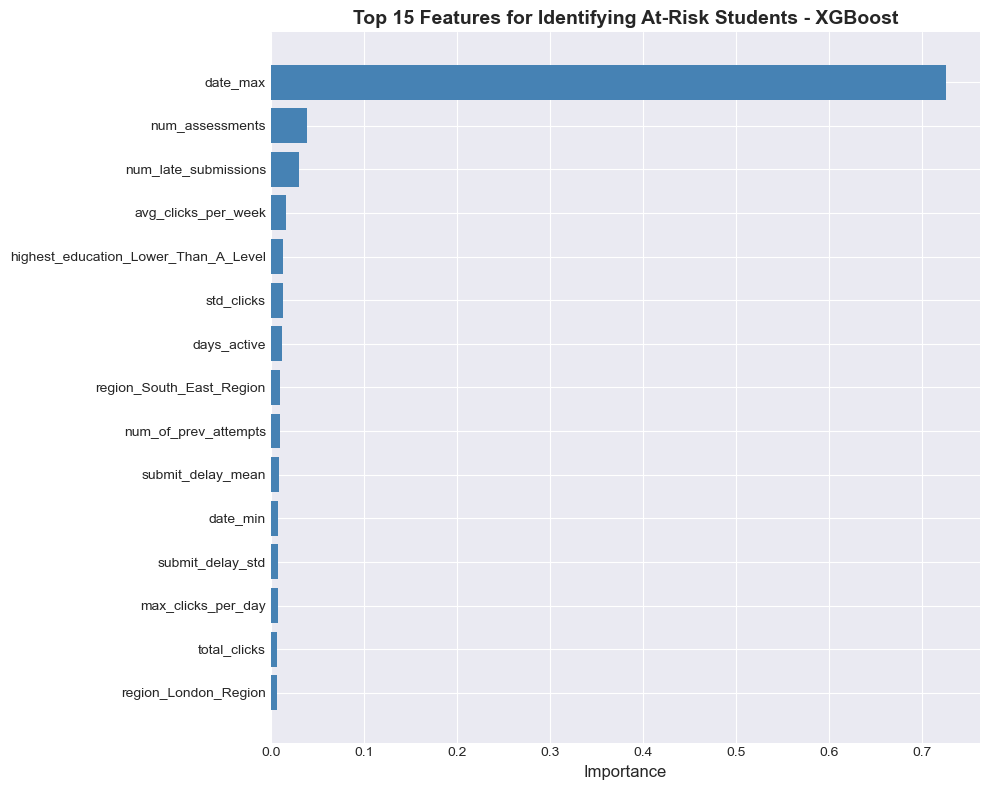


Top 15 Features:
 1. date_max                                 -> 0.725737
 2. num_assessments                          -> 0.038645
 3. num_late_submissions                     -> 0.030581
 4. avg_clicks_per_week                      -> 0.016197
 5. highest_education_Lower_Than_A_Level     -> 0.013518
 6. std_clicks                               -> 0.013338
 7. days_active                              -> 0.011797
 8. region_South_East_Region                 -> 0.009882
 9. num_of_prev_attempts                     -> 0.009782
10. submit_delay_mean                        -> 0.009281
11. date_min                                 -> 0.007533
12. submit_delay_std                         -> 0.007458
13. max_clicks_per_day                       -> 0.007347
14. total_clicks                             -> 0.006733
15. region_London_Region                     -> 0.006557


In [10]:
print('\n' + '=' * 80)
print(f'FEATURE IMPORTANCE - {best_model_name}')
print('=' * 80)

if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': features.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    top_features = feature_importance.tail(15)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(top_features)), top_features['importance'].values, color='steelblue')
    plt.yticks(range(len(top_features)), top_features['feature'].values)
    plt.xlabel('Importance', fontsize=12)
    plt.title(f'Top 15 Features for Identifying At-Risk Students - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print('\nTop 15 Features:')
    for idx, (_, row) in enumerate(feature_importance.tail(15).iloc[::-1].iterrows(), 1):
        print(f'{idx:2d}. {row["feature"]:40s} -> {row["importance"]:.6f}')
else:
    print('Feature importances not available for this model')

## Section 11: Save Best Model

In [11]:
print('\n' + '=' * 80)
print('SAVING OPTIMIZED MODEL')
print('=' * 80)

pickle.dump(best_model, open('../2_Outputs/best_binary_classification_model.pkl', 'wb'))

print(f'\n✓ Model saved: best_binary_classification_model.pkl')
print(f'  Model type: {type(best_model).__name__}')
print(f'  Test Recall (catch At-Risk): {final_results[best_model_name]["recall"]:.4f}')
print(f'  Test Precision: {final_results[best_model_name]["precision"]:.4f}')
print(f'  Test Accuracy: {final_results[best_model_name]["accuracy"]:.4f}')
print('\nReady for final analysis in 04_Final_Models.ipynb')


SAVING OPTIMIZED MODEL

✓ Model saved: best_binary_classification_model.pkl
  Model type: XGBClassifier
  Test Recall (catch At-Risk): 0.9399
  Test Precision: 0.8482
  Test Accuracy: 0.8794

Ready for final analysis in 04_Final_Models.ipynb
